In [1]:
import os
import pandas as pd
import numpy as np
from GetPoolData import get_pool_data_bigquery
from ActiveStrategyFramework import (
    simulate_strategy,
    generate_simulation_series,
    plot_strategy,
    analyze_strategy,
    plot_asset_composition,
    plot_position_value,
    aggregate_price_data,
    aggregate_swap_data,
    plot_position_return_decomposition
)
from SimpleRangeStrategy import SimpleRangeStrategy

import config
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_SERVICE_AUTH_JSON

# Pool details (UNI-ETH 0.3% pool)
uni_pool_address = "0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801"
eth_usdc_pool_address = "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640"
date_begin = "2025-01-01"
date_end = "2025-06-01"
decimals_0 = 18  # UNI (UNI-ETH pool)
decimals_1 = 18  # ETH (UNI-ETH pool)
decimals_0_eth_usdc = 6  # USDC (USDC-ETH pool)
decimals_1_eth_usdc = 18  # ETH (USDC-ETH pool)
fee_tier = 0.003  # 0.3%


# Fetch or load UNI-ETH swap data
uni_csv_file = "uni_eth_swap_data.csv"
if not os.path.exists(uni_csv_file):
    swap_data = get_pool_data_bigquery(uni_pool_address, date_begin, date_end, decimals_0, decimals_1)
    swap_data.to_csv(uni_csv_file)
else:
    swap_data = pd.read_csv(uni_csv_file, index_col='block_date', parse_dates=True)

# Fetch or load ETH-USDC swap data
eth_usdc_csv_file = "eth_usdc_data.csv"
if not os.path.exists(eth_usdc_csv_file):
    eth_usdc_data = get_pool_data_bigquery(eth_usdc_pool_address, date_begin, date_end, decimals_0_eth_usdc, decimals_1_eth_usdc)
    eth_usdc_data.to_csv(eth_usdc_csv_file)
else:
    eth_usdc_data = pd.read_csv(eth_usdc_csv_file, index_col='block_date', parse_dates=True)


In [2]:
# ETH USDC price in quotePrice is expressed as WETH / USDC
# Let's generate UNI / USD price as token_0_usd_data

eth_usdc_data = aggregate_price_data(eth_usdc_data, 'H')
eth_usdc_data['quotePrice_eth'] = 1/eth_usdc_data['quotePrice']
# print(eth_usdc_data.head())
token_0_usd_data                     = pd.merge(aggregate_price_data(swap_data,'H'),eth_usdc_data['quotePrice_eth'],left_index=True,right_index=True, how='left').ffill()

print(token_0_usd_data['quotePrice'].head())
print(token_0_usd_data['quotePrice_eth'].head())
# quotePrice is WETH / UNI and quotePrice_eth is WETH / USDC, so quotePrice_eth / quotePrice = UNI / USDC 
token_0_usd_data['quotePrice']       = token_0_usd_data['quotePrice_eth'] * token_0_usd_data['quotePrice']
print(token_0_usd_data['quotePrice'].head())


2025-01-01 00:00:00+00:00    0.003974
2025-01-01 01:00:00+00:00    0.003966
2025-01-01 02:00:00+00:00    0.003968
2025-01-01 03:00:00+00:00    0.003955
2025-01-01 04:00:00+00:00    0.003953
Freq: H, Name: quotePrice, dtype: float64
2025-01-01 00:00:00+00:00    3356.421724
2025-01-01 01:00:00+00:00    3338.567113
2025-01-01 02:00:00+00:00    3354.480523
2025-01-01 03:00:00+00:00    3347.781574
2025-01-01 04:00:00+00:00    3334.356530
Freq: H, Name: quotePrice_eth, dtype: float64
2025-01-01 00:00:00+00:00    13.339808
2025-01-01 01:00:00+00:00    13.241535
2025-01-01 02:00:00+00:00    13.311763
2025-01-01 03:00:00+00:00    13.241415
2025-01-01 04:00:00+00:00    13.181628
Freq: H, Name: quotePrice, dtype: float64


<Axes: >

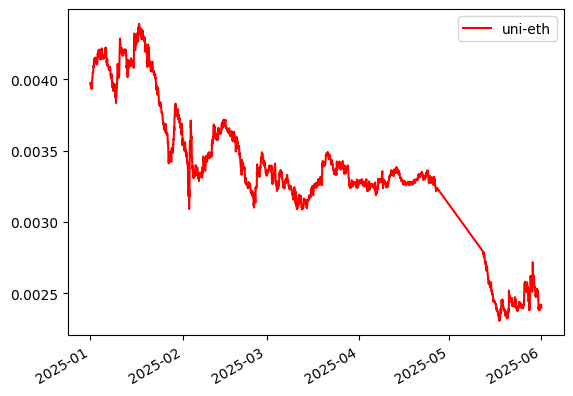

In [3]:
z_score_cutoff                = 2
window_size                   = 24*30

# Data for strategy simulation cleaning
STRATEGY_FREQUENCY                       = 'H'
# Filter according to Median Absolute Deviation (MAD)
# 1. Generate rolling median
simulate_data_filtered                   = aggregate_price_data(swap_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size)
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
# 2. Compute rolling absolute deviation of current price from median under Gaussian
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
# 3. Identify outliers based on outliers based on MAD 
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_filtered                   = simulate_data_filtered[~outlier_indices]
# 4. Generate z-scores
simulate_data_filtered['price_return']   = simulate_data_filtered['quotePrice'].pct_change()

%matplotlib inline

price_chart = pd.DataFrame({'uni-eth': simulate_data_filtered['quotePrice']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')

<Axes: >

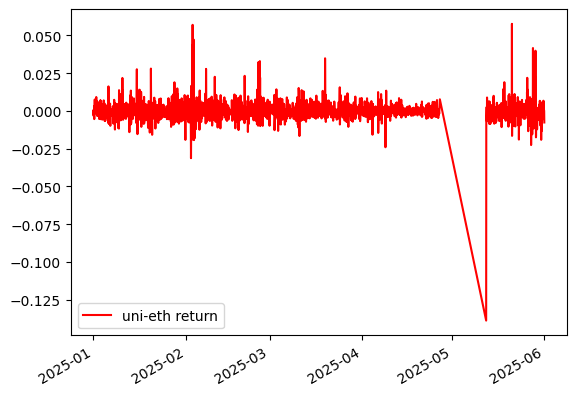

In [4]:
price_chart = pd.DataFrame({'uni-eth return': simulate_data_filtered['price_return']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')

In [5]:
# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2025-01-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2025-02-01 00:00PM',utc=True)
z_score_cutoff             = 1
window_size                = 24*30

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY                       = 'H' # evaluate the strategy every minute
simulate_data_filtered                   = aggregate_price_data(swap_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]

print("simulate_data_price length:", len(simulate_data_price))
print("simulate_data_price head:", simulate_data_price.head())
print("simulate_data_price.iloc[0]:", simulate_data_price.iloc[0])
print("simulate_data_price has NaN:", simulate_data_price.isna().any())


import importlib

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
STAT_MODEL_FREQUENCY       = 'H'

# USD Data remove outliers
token_0_usd_data_filtered  = token_0_usd_data[DATE_BEGIN:DATE_END].copy()

token_0_usd_data_filtered.to_csv('token_0_usd_data_filtered.csv')

initial_token_0_usd        = token_0_usd_data_filtered['quotePrice'].iloc[0]

# Initial Position Details
initial_usd_price          = token_0_usd_data_filtered['quotePrice'].iloc[0]
INITIAL_TOKEN_0            = 100000/initial_usd_price 

INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
FEE_TIER                   = 0.003

print("initial_usd_price:", initial_usd_price)
print("INITIAL_TOKEN_0:", INITIAL_TOKEN_0)
print("INITIAL_TOKEN_1:", INITIAL_TOKEN_1)
print("swap_data shape:", swap_data.shape)
print("swap_data quotePrice has NaN:", swap_data['quotePrice'].isna().any())
print("token_0_usd_data_filtered length:", len(token_0_usd_data_filtered))
print("token_0_usd_data_filtered head:", token_0_usd_data_filtered.head())
print("token_0_usd_data_filtered['quotePrice'] has NaN:", token_0_usd_data_filtered['quotePrice'].isna().any())


# Set decimals according to your pool
DECIMALS_0 = 18
DECIMALS_1 = 18

# Strategy Parameters
range        = [0.05]
sim_performance    = []
sim_results        = []
sim_data_collect   = []

########################################
# Single thread
########################################

import itertools
# Single thread
for j in list(itertools.product(range)):
    print("Processing width:", j[0])
    rangeStrategy = SimpleRangeStrategy(width=j[0])  # Fix: Use j[0] to extract float
    simulated_strategy = simulate_strategy(
        simulate_data_price,
        swap_data,
        rangeStrategy,
        INITIAL_TOKEN_0,
        INITIAL_TOKEN_1,
        FEE_TIER,
        decimals_0,
        decimals_1
    )
    sim_data = generate_simulation_series(
        simulated_strategy,
        rangeStrategy,
        token_0_usd_data=token_0_usd_data_filtered
    )
    strat_result = analyze_strategy(sim_data, frequency='D')
    strat_result['range'] = j[0]  # Store float value
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)
    sim_data_collect.append(sim_data)

simulate_data_price length: 745
simulate_data_price head: 2025-01-01 00:00:00+00:00    0.003974
2025-01-01 01:00:00+00:00    0.003966
2025-01-01 02:00:00+00:00    0.003968
2025-01-01 03:00:00+00:00    0.003955
2025-01-01 04:00:00+00:00    0.003953
Name: quotePrice, dtype: float64
simulate_data_price.iloc[0]: 0.0039744134920064
simulate_data_price has NaN: False
initial_usd_price: 13.339807784631649
INITIAL_TOKEN_0: 7496.359888723936
INITIAL_TOKEN_1: 29.793633882680002
swap_data shape: (60243, 22)
swap_data quotePrice has NaN: False
token_0_usd_data_filtered length: 745
token_0_usd_data_filtered head:                                      block_timestamp  block_number  \
2025-01-01 00:00:00+00:00  2025-01-01 00:38:23+00:00    21526082.0   
2025-01-01 01:00:00+00:00  2025-01-01 01:23:47+00:00    21526308.0   
2025-01-01 02:00:00+00:00  2025-01-01 02:36:59+00:00    21526673.0   
2025-01-01 03:00:00+00:00  2025-01-01 03:58:11+00:00    21527078.0   
2025-01-01 04:00:00+00:00  2025-01-01 04:5

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:325: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  net_apr                 = float((strategy_last_obs['value_position_usd']/initial_position_value - 1) * 365 / days_strategy)
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:330: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_apr'        : float((strategy_last_obs['cum_fees_usd']/initial_position_value) * 365 / days_strategy),
C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:331: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'gross_fee_return'     : float(strategy_last_obs['cum_fees_usd']/initial_position_value),
C:\Users\Z640\d

In [6]:
pd.DataFrame(sim_performance)


,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,compounds,max_drawdown,volatility,sharpe_ratio,impermanent_loss,mean_base_position,median_base_position,mean_base_width,median_base_width,final_value,range
0,31,0.090174,0.007659,0.112645,0.009567,10,0,0.19002,0.139123,0.809682,0.074355,0.079247,0.000493,0.097297,0.096034,201913.426271,0.05


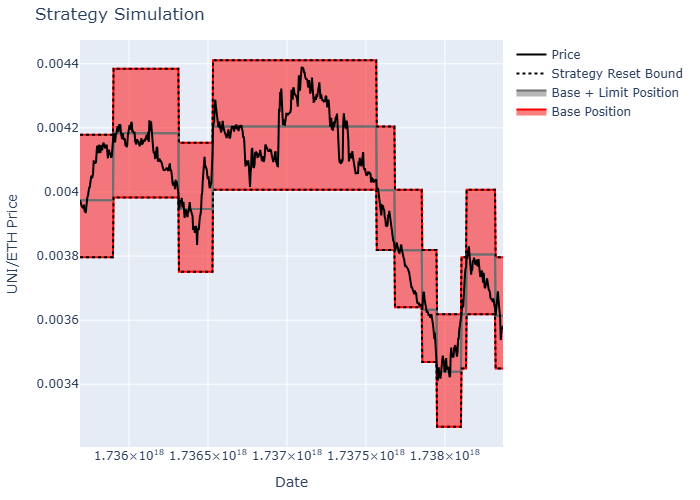

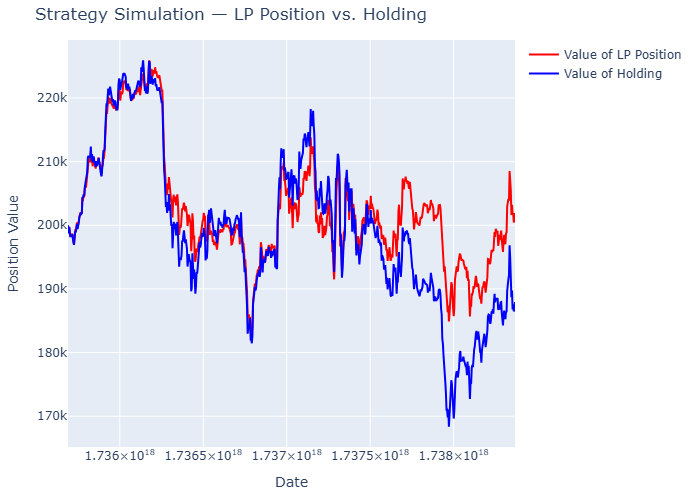

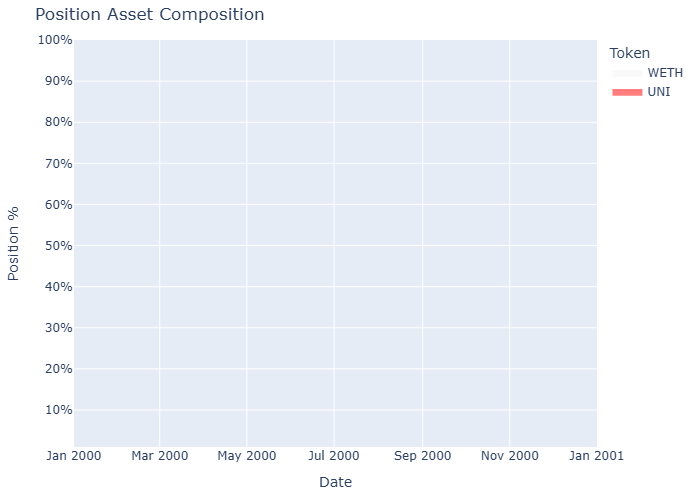

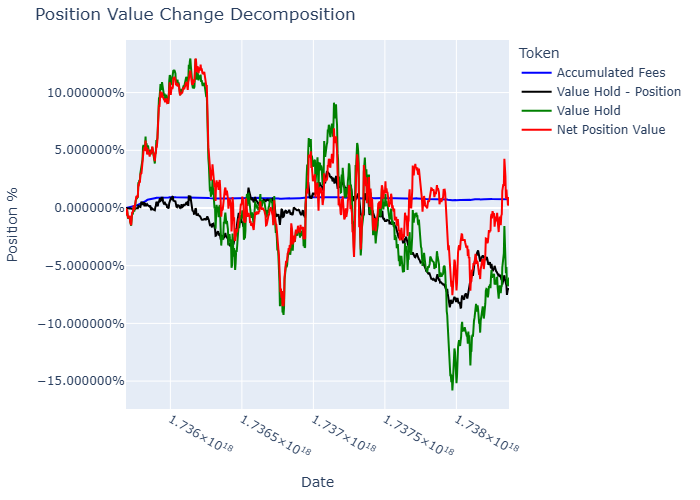

In [7]:
results = sim_data_collect[0]
results.to_csv('strategy_results.csv')
p = plot_strategy(results,'UNI/ETH Price')
p = plot_position_value(results)
p =plot_asset_composition(results,'UNI','WETH')
p = plot_position_return_decomposition(results)

In [9]:
frequency = 'H'  # Daily resampling

# Ensure timezones are UTC
swap_data.index = pd.to_datetime(swap_data.index, utc=True)
eth_usdc_data.index = pd.to_datetime(eth_usdc_data.index, utc=True)

price_data_file = 'uni_eth_price_data.csv'
# Aggregate price data for UNI-ETH
price_data = aggregate_price_data(swap_data[['quotePrice']], frequency)
price_data.to_csv(price_data_file)

print("price_data columns:", price_data.columns)


swap_data_file = 'uni_eth_resampled_swap_data.csv'
# Aggregate swap data for UNI-ETH
swap_data_resampled = aggregate_swap_data(swap_data, frequency)
swap_data_resampled.to_csv(swap_data_file)
print("swap_data_resampled columns:", swap_data_resampled.columns)

# Create token_0_usd_data for ETH/USD prices
eth_usdc_data = aggregate_price_data(eth_usdc_data[['quotePrice']], frequency)
eth_usdc_data['quotePrice_eth'] = 1/eth_usdc_data['quotePrice']  # ETH/USDC

token_0_usd_data = pd.merge(
    swap_data_resampled,  # UNI/ETH 
    eth_usdc_data[['quotePrice_eth']],  # ETH/USDC
    left_index=True,
    right_index=True,
    how='left'
).ffill()
token_0_usd_data['quotePrice'] = token_0_usd_data['quotePrice_eth'] * swap_data_resampled['quotePrice']
token_0_usd_data.to_csv('token_0_usd_data.csv')

# Initialize strategy
strategy = SimpleRangeStrategy(width=0.1)  # 5% range
initial_liquidity_0 = 2000  # UNI
initial_liquidity_1 = initial_liquidity_0 * price_data['quotePrice'].iloc[0]  # UNI for 50/50 value

# Run simulation
simulations = simulate_strategy(
    price_data['quotePrice'],
    swap_data_resampled,
    strategy,
    initial_liquidity_0,
    initial_liquidity_1,
    fee_tier,
    decimals_0,
    decimals_1
)



price_data columns: Index(['quotePrice', 'price_return'], dtype='object')
swap_data_resampled columns: Index(['block_timestamp', 'block_number', 'transaction_hash', 'log_index',
       'contract_address', 'sender', 'recipient', 'amount0', 'amount1',
       'sqrtPriceX96', 'liquidity', 'tick', 'sqrtPriceX96_float', 'quotePrice',
       'block_date.1', 'tick_swap', 'amount0_adj', 'amount1_adj',
       'virtual_liquidity', 'virtual_liquidity_adj', 'token_in', 'traded_in'],
      dtype='object')


In [10]:
# Generate results with USD data
results = generate_simulation_series(simulations, strategy, token_0_usd_data=token_0_usd_data)

# Analyze and plot
summary = analyze_strategy(results, frequency=frequency)


C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:325: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:330: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:331: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:333: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



In [ ]:
print("Strategy Summary:", summary)

results.to_csv('strategy_results.csv')


Strategy Summary: {'days_strategy': 150, 'gross_fee_apr': 0.09314687114085567, 'gross_fee_return': 0.03827953608528315, 'net_apr': -0.39717810197882975, 'net_return': -0.16322387752554646, 'rebalances': 11, 'compounds': 0, 'max_drawdown': 0.5963264990602055, 'volatility': 0.8379218255360104, 'sharpe_ratio': -0.47400376726642585, 'impermanent_loss': 0.38445107808108114, 'mean_base_position': 0.10630441340968817, 'median_base_position': 8.034436224745018e-08, 'mean_base_width': 0.191604496542363, 'median_base_width': 0.19214735599160956, 'final_value': 44649.7305303144}


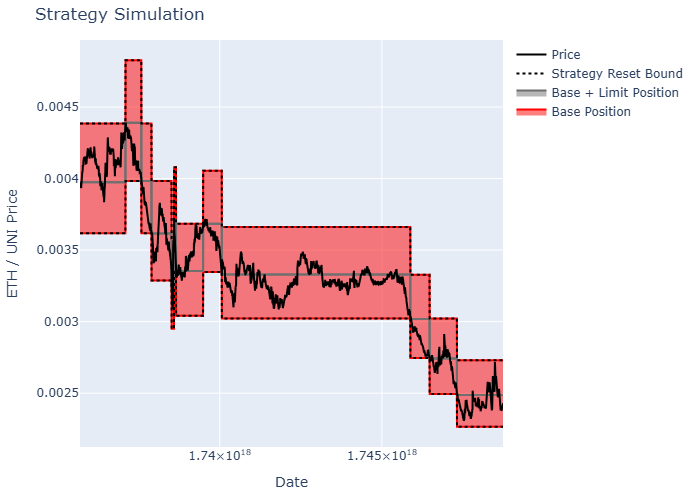

In [ ]:
p = plot_strategy(results,'UNI/ETH Price')

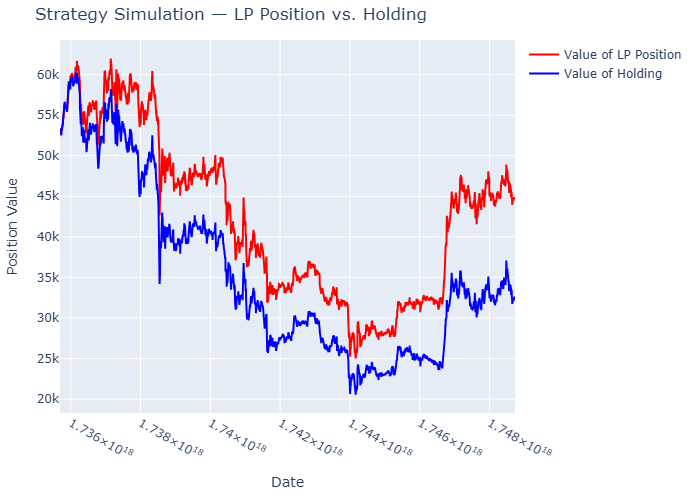

In [14]:
p = plot_position_value(results)

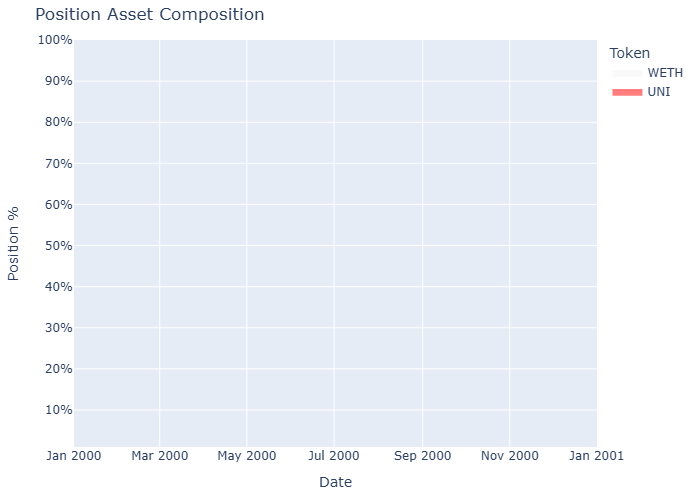

In [ ]:

p = plot_position_value(results)
p =plot_asset_composition(results,'UNI','WETH')

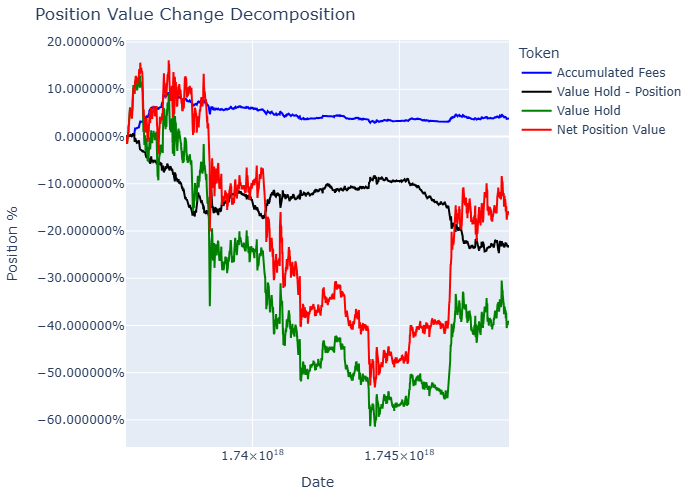

In [ ]:


p = plot_position_value(results)
p =plot_asset_composition(results,'UNI','WETH')
p = plot_position_return_decomposition(results)

In [4]:
results.head()

,time_pd,time,price,reset_point,compound_point,reset_reason,base_range_lower,base_range_upper,limit_range_lower,limit_range_upper,...,limit_position_value_in_token_0,price_0_usd,value_position_usd,base_position_value_usd,limit_position_value_usd,cum_fees_0,cum_fees_usd,token_0_hold_usd,token_1_hold_usd,value_hold_usd
0,2025-01-01 00:00:00+00:00,2025-01-01 00:00:00+00:00,0.003974,False,False,,0.003796,0.004179,0.003974,0.003974,...,0.0,13.339808,26679.615569,25523.175552,0.0,0.000000,0.000000,13339.807785,13339.807785,26679.615569
1,2025-01-01 01:00:00+00:00,2025-01-01 01:00:00+00:00,0.003966,False,False,,0.003796,0.004179,0.003974,0.003974,...,0.0,13.241535,26510.524012,25359.551381,0.0,0.051681,0.684340,13241.535277,13268.846178,26510.381455
2,2025-01-01 02:00:00+00:00,2025-01-01 02:00:00+00:00,0.003968,False,False,,0.003796,0.004179,0.003974,0.003974,...,0.0,13.311763,26645.686797,25487.790100,0.0,0.159699,2.125879,13311.763098,13332.092649,26643.855747
3,2025-01-01 03:00:00+00:00,2025-01-01 03:00:00+00:00,0.003955,False,False,,0.003796,0.004179,0.003974,0.003974,...,0.0,13.241415,26546.691449,25390.361416,0.0,0.216200,2.862790,13241.415215,13305.468257,26546.883472
4,2025-01-01 04:00:00+00:00,2025-01-01 04:00:00+00:00,0.003953,False,False,,0.003796,0.004179,0.003974,0.003974,...,0.0,13.181628,26432.978192,25281.175546,0.0,0.224575,2.960268,13181.628140,13252.111582,26433.739722


In [16]:

from ActiveStrategyFramework import (
    simulate_strategy,
    generate_simulation_series,
    plot_strategy,
    analyze_strategy,
    aggregate_price_data,
    aggregate_swap_data
)

frequency = 'H'  # Daily resampling

# Ensure index is timezone-aware (UTC)
swap_data.index = pd.to_datetime(swap_data.index, utc=True)

# Resample price data
price_data = aggregate_price_data(swap_data[['quotePrice']], frequency)

# Resample swap data
swap_data_resampled = aggregate_swap_data(swap_data, frequency)

print("price_data columns:", price_data.columns)
print("price_data['quotePrice'] type:", type(price_data['quotePrice']))

print("swap_data_resampled columns:", swap_data_resampled.columns)

print(price_data.head())
print(swap_data_resampled.head())

# Initialize strategy
strategy = SimpleRangeStrategy(width=0.1)  # 5% range
initial_liquidity_0 = 1000  # 1 ETH
initial_liquidity_1 = 3.0  # 100 UNI

# Run simulation
simulations = simulate_strategy(
    price_data['quotePrice'],  # Pass the resampled price series
    swap_data_resampled,       # Pass the resampled swap data
    strategy,
    initial_liquidity_0,
    initial_liquidity_1,
    fee_tier,
    decimals_0,
    decimals_1
)

# Generate results
results = generate_simulation_series(simulations, strategy)

# Analyze and plot
summary = analyze_strategy(results, frequency=frequency)


price_data columns: Index(['quotePrice', 'price_return'], dtype='object')
price_data['quotePrice'] type: <class 'pandas.core.series.Series'>
swap_data_resampled columns: Index(['block_timestamp', 'block_number', 'transaction_hash', 'log_index',
       'contract_address', 'sender', 'recipient', 'amount0', 'amount1',
       'sqrtPriceX96', 'liquidity', 'tick', 'sqrtPriceX96_float', 'quotePrice',
       'block_date.1', 'tick_swap', 'amount0_adj', 'amount1_adj',
       'virtual_liquidity', 'virtual_liquidity_adj', 'token_in', 'traded_in'],
      dtype='object')
                           quotePrice  price_return
2025-01-01 00:00:00+00:00    0.003974           NaN
2025-01-01 01:00:00+00:00    0.003966     -0.002058
2025-01-01 02:00:00+00:00    0.003968      0.000535
2025-01-01 03:00:00+00:00    0.003955     -0.003294
2025-01-01 04:00:00+00:00    0.003953     -0.000507
                                     block_timestamp  block_number  \
block_date                                            

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:325: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:330: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:331: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Z640\dev\newsim\univ3-strategies\ActiveStrategyFramework.py:333: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



Strategy Summary: {'days_strategy': 169, 'gross_fee_apr': 0.43281580991157925, 'gross_fee_return': 0.20039964897275864, 'net_apr': 0.669004912362847, 'net_return': 0.30975843887485244, 'rebalances': 12, 'compounds': 0, 'max_drawdown': 0.2624464991730522, 'volatility': 0.14106456420590127, 'sharpe_ratio': 4.7425440692983045, 'impermanent_loss': 0.15939897129849973, 'mean_base_position': 0.148538488494556, 'median_base_position': 0.002562314184985013, 'mean_base_width': 0.1910069147132592, 'median_base_width': 0.19214735599160956, 'final_value': 2298.4012473112098}


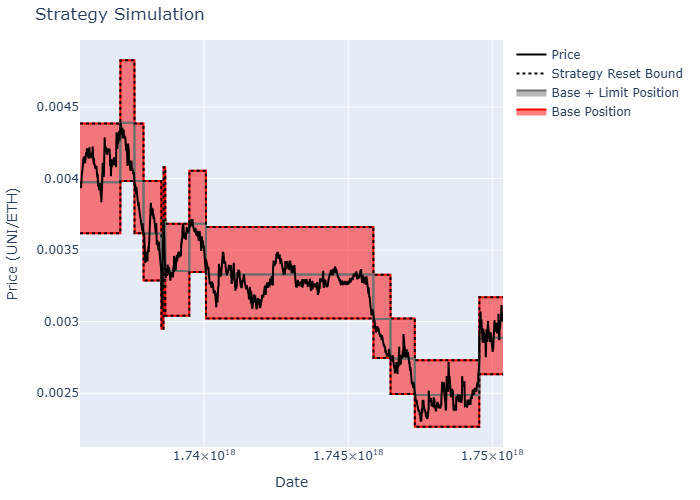

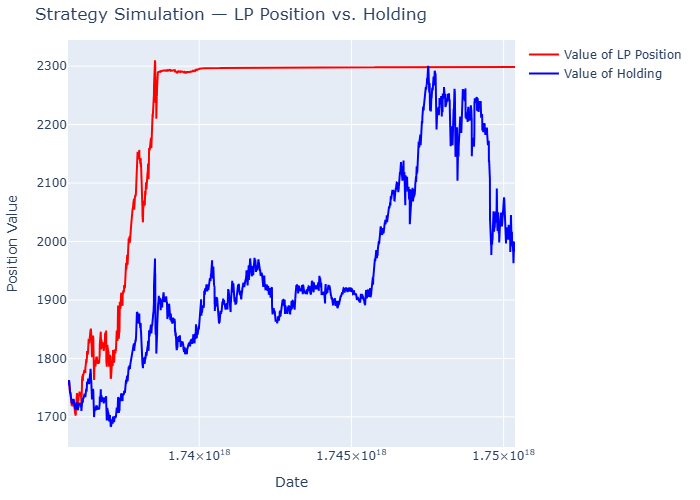

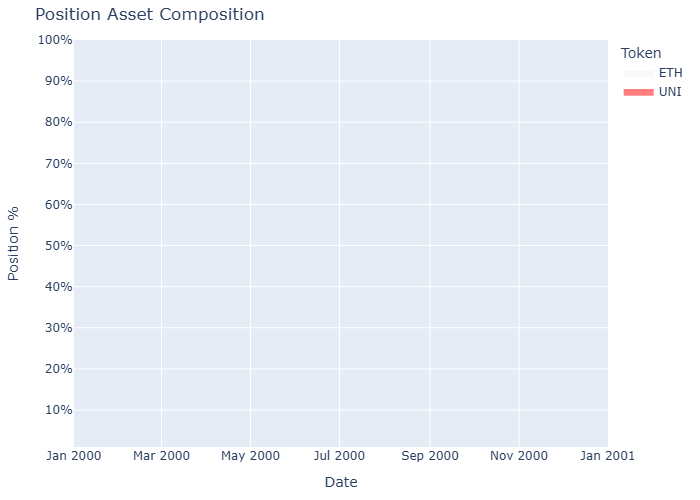

In [13]:
print("Strategy Summary:", summary)
plot_strategy(results, y_axis_label="Price (UNI/ETH)")

plot_position_value(results)
plot_asset_composition(results,"UNI", "ETH")

ValueError: If using all scalar values, you must pass an index